In [1]:
import tensorflow as tf
from collections import Counter
import os
from sklearn.model_selection import train_test_split

#import keras
from tensorflow import keras
import tensorflow.keras.layers as kl
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dropout, Reshape, Dense, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, InputLayer, Input
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint

In [2]:
tf.config.experimental.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
### set GPU for tensorflow
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import pandas as pd
import numpy as np

import sys
sys.path.append('Neural_Network_DNA_Demo/')
from helper import IOHelper, SequenceHelper # from https://github.com/const-ae/Neural_Network_DNA_Demo

import random
random.seed(1234)

## Data

In [5]:
CHROMS = np.r_[np.arange(1,23), ["X"]]
CHROMS

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X'],
      dtype='<U21')

In [6]:
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data"
lst = list()

for chrom in CHROMS:
    ###
    fname = "chr" + chrom + ".fa"
    fpath = os.path.join(fdiry, fname)
    print(fpath, flush = True)
    dat = IOHelper.get_fastas_from_file(fpath, uppercase=True)
    
    ###
    lst.append(dat)

dat_fasta = pd.concat(lst).reset_index()
dat_fasta

/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr1.fa
Sequence Length: 1000
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr2.fa
Sequence Length: 1000
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr3.fa
Sequence Length: 1000
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr4.fa
Sequence Length: 1000
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr5.fa
Sequence Length: 1000
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr6.fa
Sequence Length: 1000
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr7.fa
Sequence Length: 1000
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr8.fa
Sequence Length: 1000
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr9.fa
Sequence Length: 1000
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr10.fa
Sequence Length: 1000
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_

,index,location,sequence
0,0,chr1:778232-779232,TCCCTGTTGCACACCTGGATAGTTTTTTAAATTTTTTTAGACAGGG...
1,1,chr1:818441-819441,ATGCTTACCAGGGCTGGAGGCCCCTGTGAGTAGTGAAGTGCATGTG...
2,2,chr1:826644-827644,ATTCTGTCCTCCATATCTCTGCTGATTCCCATTTTGTCTATTTCCA...
3,3,chr1:851117-852117,TGTCTTTATAGCAGCATGATTTATAGTCCTTTGGGTATATACCCAG...
4,4,chr1:856205-857205,CATTCCCGGATCCAAGGTCCTGCCTCTGTCCTGTCCCCTGAGCCAC...
...,...,...,...
87904,3426,chrX:155434820-155435820,TTTTTCAAAAGAAAAGCAATGAGGATCAGAAAGGTGAAGATACTAG...
87905,3427,chrX:155435206-155436206,ACGCTCTTCCCATGTATCTTTGTAATTTGCTGATCAGGAGATCCCC...
87906,3428,chrX:155440330-155441330,AAGGGGAGGCAAACACATCCTTCTTCACAGGGTGGCAGCAAGGAGA...
87907,3429,chrX:155521212-155522212,TTTCTGGTTGTTAGTTTTCCTTCTAACAGACAGGACCCTCAGCTGC...


dat_fasta = IOHelper.get_fastas_from_file(
    "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr17.fa", 
    uppercase=True)

In [10]:
tmp = dat_fasta.sequence.apply(lambda seq: len(seq))
Counter(tmp)

Counter({1000: 87909})

In [11]:
sequence_length = len(dat.sequence[0])
print(f"Sequence Length: {sequence_length}")

Sequence Length: 1000


In [12]:
# Convert sequence to one hot encoding matrix
seq_matrix = SequenceHelper.do_one_hot_encoding(
    dat_fasta.sequence, 
    sequence_length,
    SequenceHelper.parse_alpha_to_seq)

In [15]:
print(seq_matrix.shape)

(87909, 1000, 4)


In [14]:
X = np.nan_to_num(seq_matrix) # Replace NaN with zero and infinity with large finite numbers
X_reshaped = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

In [18]:
# fpath = "/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/
# ... dat_score_chr17.tsv"
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results"
lst = list()

for chrom in CHROMS:
    ###
    fname = "dat_score_chr" + chrom + ".tsv"
    fpath = os.path.join(fdiry, fname)
    print(fpath, flush = True)
    dat = pd.read_table(fpath)
    
    ###
    lst.append(dat)

dat_activity = pd.concat(lst)
dat_activity

/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr1.tsv
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr2.tsv
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr3.tsv
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr4.tsv
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr5.tsv
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr6.tsv
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr7.tsv
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr8.tsv
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr9.tsv
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr10.tsv
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr11.tsv
/home/mount/work/out/proj_combeffect/peak

,Chrom,Start,End,Name,Log2_Score_DMSO,Log2_Score_Dex
0,chr1,778232,779232,chr1:778588-778877:DMSO,1.372734,1.048260
1,chr1,818441,819441,chr1:818351-819531:Dex,0.717290,2.508601
2,chr1,826644,827644,chr1:826715-827573:DMSO,1.905313,1.410864
3,chr1,851117,852117,chr1:851268-851966:DMSO,1.819445,1.150065
4,chr1,856205,857205,chr1:856338-857072:Dex,0.603458,1.091726
...,...,...,...,...,...,...
3426,chrX,155434820,155435820,chrX:155435035-155435606:Dex,1.535949,1.507972
3427,chrX,155435206,155436206,chrX:155435256-155436156:DMSO,1.450265,1.389878
3428,chrX,155440330,155441330,chrX:155440404-155441256:DMSO,1.127618,0.222461
3429,chrX,155521212,155522212,chrX:155521256-155522169:Dex,1.649832,1.865266


In [21]:
dat_fasta.location

0              chr1:778232-779232
1              chr1:818441-819441
2              chr1:826644-827644
3              chr1:851117-852117
4              chr1:856205-857205
                   ...           
87904    chrX:155434820-155435820
87905    chrX:155435206-155436206
87906    chrX:155440330-155441330
87907    chrX:155521212-155522212
87908    chrX:155521255-155522255
Name: location, Length: 87909, dtype: object

In [19]:
dat_activity.Name

0             chr1:778588-778877:DMSO
1              chr1:818351-819531:Dex
2             chr1:826715-827573:DMSO
3             chr1:851268-851966:DMSO
4              chr1:856338-857072:Dex
                    ...              
3426     chrX:155435035-155435606:Dex
3427    chrX:155435256-155436156:DMSO
3428    chrX:155440404-155441256:DMSO
3429     chrX:155521256-155522169:Dex
3430    chrX:155521377-155522133:DMSO
Name: Name, Length: 87909, dtype: object

In [23]:
Y_dmso = dat_activity.Log2_Score_DMSO
Y_dex  = dat_activity.Log2_Score_Dex
Y = np.array([Y_dmso, Y_dex])
Y = Y.T

In [25]:
print(X_reshaped.shape)
print(Y.shape)

(87909, 1000, 4)
(87909, 2)


In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_reshaped, 
    Y, 
    test_size=0.2, 
    random_state=123)

## import data

In [5]:
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data"

fname = "whole_genome_X.npy"
fpath = os.path.join(fdiry, fname)
with open(fpath, 'rb') as file:
    X = np.load(file)

fname = "whole_genome_Y.npy"
fpath = os.path.join(fdiry, fname)
with open(fpath, 'rb') as file:
    Y = np.load(file)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, 
    Y, 
    test_size=0.2, 
    random_state=123)

In [15]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(70327, 1000, 4)
(17582, 1000, 4)
(70327, 2)
(17582, 2)


In [17]:
Y_train = [y_train[:,0], y_train[:,1]]
Y_valid = [y_valid[:,0], y_valid[:,1]]
#Y_train = y_train
#Y_valid = y_valid

In [14]:
print(X_train.shape)
print(X_valid.shape)
print(Y_train[0].shape)
print(Y_valid[0].shape)

(70327, 1000, 4)
(17582, 1000, 4)
(2,)


NameError: name 'Y_valid' is not defined

In [8]:
### Additional metrics
from scipy.stats import spearmanr
def Spearman(y_true, y_pred):
     return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32), 
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )

In [10]:
params = {'batch_size': 128,
          'epochs': 10,
          'early_stop': 10,
          'kernel_size1': 7,
          'kernel_size2': 3,
          'kernel_size3': 5,
          'kernel_size4': 3,
          'kernel_size5': 3,
          'lr': 0.002,
          'num_filters': 256,
          'num_filters2': 60,
          'num_filters3': 60,
          'num_filters4': 120,
          'num_filters5': 120,
          #'n_conv_layer': 4,
          'n_conv_layer': 5,
          'n_add_layer':  2,
          'dropout_prob': 0.4,
          'dense_neurons1': 256,
          'dense_neurons2': 256,
          'pad':'same'}

def DeepSTARR(params=params):
    
    lr = params['lr']
    dropout_prob = params['dropout_prob']
    n_conv_layer = params['n_conv_layer']
    n_add_layer = params['n_add_layer']
    
    # body
    #input = kl.Input(shape=(249, 4))
    input = kl.Input(shape=(1000, 4))
    x = kl.Conv1D(params['num_filters'], kernel_size=params['kernel_size1'],
                  padding=params['pad'],
                  name='Conv1D_1st')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)

    for i in range(1, n_conv_layer):
        x = kl.Conv1D(params['num_filters'+str(i+1)],
                      kernel_size=params['kernel_size'+str(i+1)],
                      padding=params['pad'],
                      name=str('Conv1D_'+str(i+1)))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    # dense layers
    for i in range(0, n_add_layer):
        x = kl.Dense(params['dense_neurons'+str(i+1)],
                     name=str('Dense_'+str(i+1)))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_prob)(x)
    bottleneck = x
    
    # heads per task (developmental and housekeeping enhancer activities)
    #tasks = ['Dev', 'Hk']
    tasks = ['DMSO', 'Dex']
    outputs = []
    for task in tasks:
        outputs.append(kl.Dense(1, activation='linear', name=str('Dense_' + task))(bottleneck))

    model = tf.keras.models.Model([input], outputs)
    model.compile(tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=['mse', 'mse'], # loss
                  loss_weights=[1, 1], # loss weigths to balance
                  metrics=[Spearman]) # additional track metric

    return model, params

DeepSTARR()[0].summary()
DeepSTARR()[1] # dictionary

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
Conv1D_1st (Conv1D)             (None, 1000, 256)    7424        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 1000, 256)    1024        Conv1D_1st[0][0]                 
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 1000, 256)    0           batch_normalization_14[0][0]     
____________________________________________________________________________________________

{'batch_size': 128,
 'epochs': 10,
 'early_stop': 10,
 'kernel_size1': 7,
 'kernel_size2': 3,
 'kernel_size3': 5,
 'kernel_size4': 3,
 'kernel_size5': 3,
 'lr': 0.002,
 'num_filters': 256,
 'num_filters2': 60,
 'num_filters3': 60,
 'num_filters4': 120,
 'num_filters5': 120,
 'n_conv_layer': 5,
 'n_add_layer': 2,
 'dropout_prob': 0.4,
 'dense_neurons1': 256,
 'dense_neurons2': 256,
 'pad': 'same'}

In [18]:
def train(selected_model, X_train, Y_train, X_valid, Y_valid, params):

    my_history=selected_model.fit(X_train, Y_train,
                                  validation_data=(X_valid, Y_valid),
                                  batch_size=params['batch_size'], epochs=params['epochs'],
                                  callbacks=[EarlyStopping(patience=params['early_stop'], monitor="val_loss", restore_best_weights=True),
                                             History()])
    
    return selected_model, my_history

In [19]:
main_model, main_params = DeepSTARR()
main_model, my_history = train(main_model, X_train, Y_train, X_valid, Y_valid, main_params)

ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[0.50823895, 1.18173257],
       [1.04618983, 0.96931378],
       [0.49112468, 1.44471417],
       ...,
       [0.45041924, 0.0989796 ],
       [2.09559252, 3.18101068],
       [1.33785767, 1....

In [43]:
my_history

In [44]:
my_history.history.keys()

dict_keys(['loss', 'Dense_DMSO_loss', 'Dense_Dex_loss', 'Dense_DMSO_Spearman', 'Dense_Dex_Spearman', 'val_loss', 'val_Dense_DMSO_loss', 'val_Dense_Dex_loss', 'val_Dense_DMSO_Spearman', 'val_Dense_Dex_Spearman'])

In [45]:
def plot_loss_acc(axs, history, has_validate=False):
    """..."""
    ### history
    h = history
    loss_trn = h["loss"]
    acc_trn  = h["Dense_Dex_Spearman"]
    x = np.arange(len(loss_trn)) + 1
    
    ### plot loss
    ax = axs[0]
    ax.plot(x, loss_trn, "o-", color="blue", label="Train")
    ax.set_title("Loss")
    
    ### plot accuracy
    ax = axs[1]
    ax.plot(x, acc_trn, "o-", color="blue", label="Train")
    ax.set_title("Dense_Dex_Spearman")
    
    ### plot validation if has_validate
    if has_validate:
        loss_val = h["val_loss"]
        acc_val  = h["val_Dense_Dex_Spearman"]
    
        ax = axs[0]
        ax.plot(x, loss_val, "o-", color="orange", label="Validation")
        ax.set_title("Loss (Validation)")
        
        ax = axs[1]
        ax.plot(x, acc_val, "o-", color="orange", label="Validation")
        ax.set_title("val_Dense_Dex_Spearman")

In [46]:
import matplotlib.pyplot as plt

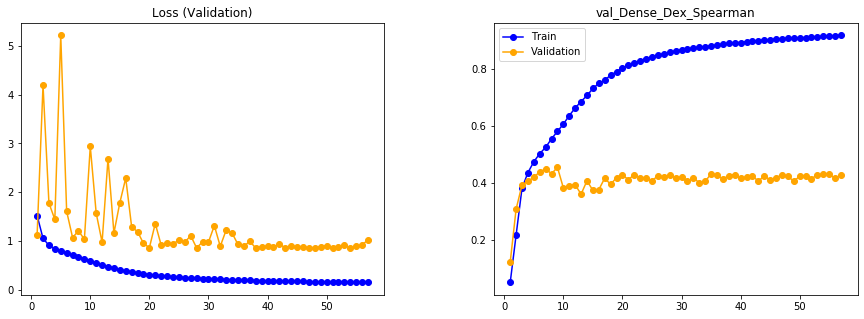

In [47]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plot_loss_acc(axes, my_history.history, has_validate=True)
plt.legend()
plt.show()

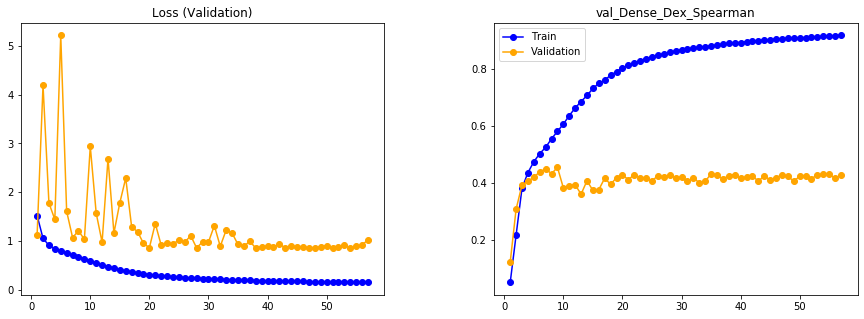

In [48]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plot_loss_acc(axes, my_history.history, has_validate=True)
plt.legend()
plt.show()

In [49]:
from scipy import stats
from sklearn.metrics import mean_squared_error

# create functions
#tasks = ['DMSO', 'Dex']
TASK1 = 'DMSO'
TASK2 = 'Dex'
def summary_statistics(X, Y, set, task):
    pred = main_model.predict(X, batch_size=main_params['batch_size'])
    #if task =="Dev":
    if task == TASK1:
        i=0
    #if task =="Hk":
    if task == TASK2:
        i=1
    print(set + ' MSE ' + task + ' = ' + str("{0:0.2f}".format(mean_squared_error(Y, pred[i].squeeze()))))
    print(set + ' PCC ' + task + ' = ' + str("{0:0.2f}".format(stats.pearsonr(Y, pred[i].squeeze())[0])))
    print(set + ' SCC ' + task + ' = ' + str("{0:0.2f}".format(stats.spearmanr(Y, pred[i].squeeze())[0])))
    
# run for each set and enhancer type
#summary_statistics(X_train, Y_train[0], "train", "Dev")
#summary_statistics(X_train, Y_train[1], "train", "Hk")
#summary_statistics(X_valid, Y_valid[0], "validation", "Dev")
#summary_statistics(X_valid, Y_valid[1], "validation", "Hk")
#summary_statistics(X_test, Y_test[0], "test", "Dev")
#summary_statistics(X_test, Y_test[1], "test", "Hk")

summary_statistics(X_train, Y_train[0], "train", TASK1)
summary_statistics(X_train, Y_train[1], "train", TASK2)
summary_statistics(X_valid, Y_valid[0], "validation", TASK1)
summary_statistics(X_valid, Y_valid[1], "validation", TASK2)
#summary_statistics(X_test, Y_test[0], "test", TASK1)
#summary_statistics(X_test, Y_test[1], "test", TASK2)

train MSE DMSO = 0.04
train PCC DMSO = 0.97
train SCC DMSO = 0.96
train MSE Dex = 0.04
train PCC Dex = 0.96
train SCC Dex = 0.95
validation MSE DMSO = 0.41
validation PCC DMSO = 0.65
validation SCC DMSO = 0.64
validation MSE Dex = 0.44
validation PCC Dex = 0.47
validation SCC Dex = 0.43


In [50]:
import os

In [51]:
ls /home/mount/work/out/proj_combeffect/peak

cradle/  cradle_deepstarr_data/  cradle_deepstarr_results/  cradle_peak_count/


In [52]:
fdiry = "/home/mount/work/out/proj_combeffect/peak"
os.listdir(fdiry)

['.ipynb_checkpoints',
 'cradle_deepstarr_results',
 'cradle_peak_count',
 'cradle',
 'cradle_deepstarr_data']

In [53]:
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
os.listdir(fdiry)

['chr17_Model_DeepSTARR_Dex_modisco.h5',
 'Model_DeepSTARR.json',
 'Model_DeepSTARR.h5',
 'chr17_Model_DeepSTARR_Dex_contribution_scores.h5']

In [54]:
#model_name="DeepSTARR"

#model_json = main_model.to_json()
#with open('Model_' + model_name + '.json', "w") as json_file:
#    json_file.write(model_json)
#main_model.save_weights('Model_' + model_name + '.h5')

model_name = "DeepSTARR"
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results" 

model_json = main_model.to_json()
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
fname = 'Model_' + model_name + '.json'
fpath = os.path.join(fdiry, fname)
with open(fpath, "w") as json_file:
    json_file.write(model_json)
    
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
fname = 'Model_' + model_name + '.h5'
fpath = os.path.join(fdiry, fname)
main_model.save_weights(fpath)